In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb

color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 9999

First let us look at the files given for the competition.

In [5]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print("Train rows and columns : ", train_df.shape)
print("Test rows and columns : ", test_df.shape)

Train rows and columns :  (4459, 4993)
Test rows and columns :  (49342, 4992)


So we have 4459 rows in train set and 49342 rows in test set. We also have 4993 columns in total including the target and id column.

Observations:

Test set is almost 10 times as that of train set.
Public LB uses 49% of the test set for evaluation. So may be it is better to give some (if not more) weightage to LB scores.
Number of columns is more than the number of train rows. So need to be careful with feature selection / engineering

In [6]:
train_df.head()

ID      target  48df886f9  0deb4b6a8  34b15f335  a8cb14b00  \
0  000d6aaf2  38000000.0        0.0          0        0.0          0   
1  000fbd867    600000.0        0.0          0        0.0          0   
2  0027d6b71  10000000.0        0.0          0        0.0          0   
3  0028cbf45   2000000.0        0.0          0        0.0          0   
4  002a68644  14400000.0        0.0          0        0.0          0   

   2f0771a37  30347e683  d08d1fbe3  6ee66e115  20aa07010  dc5a8f1d8  \
0          0          0          0          0        0.0        0.0   
1          0          0          0          0  2200000.0        0.0   
2          0          0          0          0        0.0        0.0   
3          0          0          0          0        0.0        0.0   
4          0          0          0          0  2000000.0        0.0   

   11d86fa6a  77c9823f2  8d6c2a0b2  4681de4fd  adf119b9a  cff75dd09  \
0        0.0          0          0          0          0        0.0   
1        0.0          0          0          0          0        0.0   
2        0.0          0          0          0          0        0.0   
3        0.0          0          0          0          0        0.0   
4        0.0          0          0          0          0        0.0   

   96f83a237  b8a716ebf  6c7a4567c  4fcfd2b4d  f3b9c0b95  71cebf11c  \
0          0        0.0          0          0        0.0          0   
1          0        0.0          0          0        0.0          0   
2          0        0.0          0          0        0.0          0   
3          0        0.0          0          0        0.0          0   
4          0        0.0          0          0        0.0          0   

   d966ac62c  68b647452  c88d108c9  ff7b471cd  d5308d8bc  0d866c3d7  \
0          0        0.0          0          0          0        0.0   
1          0        0.0          0          0          0        0.0   
2          0        0.0          0          0          0        0.0   
3          0        0.0          0          0          0        0.0   
4          0        0.0          0          0          0        0.0   

   bc3f77679  bd8f989f1  0eff5bf95  22ed6dba3  92b13ebba  c330f1a67  \
0          0        0.0          0        0.0        0.0          0   
1          0        0.0          0        0.0        0.0          0   
2          0        0.0          0        0.0        0.0          0   
3          0        0.0          0        0.0        0.0          0   
4          0        0.0          0        0.0        0.0          0   

   233c7c17c  2cb4d123e  eeac16933  87ffda550  822e49b95  316b978cd  \
0        0.0          0          0  1300000.0        0.0          0   
1        0.0          0          0        0.0        0.0          0   
2        0.0          0          0        0.0        0.0          0   
3        0.0          0          0        0.0        0.0          0   
4        0.0          0          0        0.0        0.0          0   

   d04e16aed  5d5c5ce6d  ec863cb52  11ad148bd  ea18d720e  408d86ce9  \
0        0.0          0          0        0.0        0.0        0.0   
1        0.0          0          0        0.0        0.0        0.0   
2        0.0          0          0        0.0        0.0        0.0   
3        0.0          0          0        0.0        0.0        0.0   
4        0.0          0          0        0.0        0.0        0.0   

   69d8b4020  b0868a049  80b14398e  ecdef52b2  c36bcacc5  151d318cd  \
0          0          0        0.0        0.0          0          0   
1          0          0        0.0        0.0          0          0   
2          0          0        0.0        0.0          0          0   
3          0          0        0.0        0.0          0          0   
4          0          0        0.0        0.0          0          0   

   ab0cddb90  2d6bd8275   dfdf4b580  c87722678  a8c320153  7df8788e8  \
0          0        0.0         0.0          0          0          0   
1          0     

Observations:

The column names are anonymized and so we do not know what they mean
There are many zero values present in the data
From this discussion post, the dataset is a sparse tabular one.

# Target Variable

Let us first do a scatter plot of the target variable to see if there are any visible outliers.

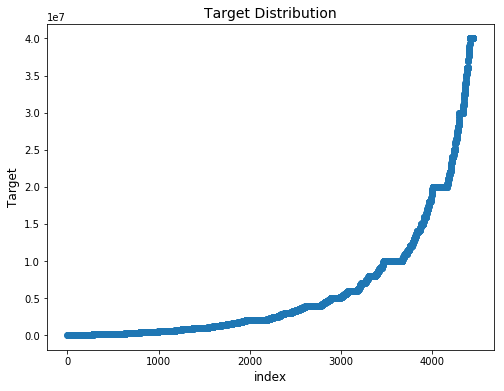

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['target'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.title("Target Distribution", fontsize=14)
plt.show()

Looks like there are not any visible outliers in the data but the range is quite high.

We can now do a histogram plot of the target variable.

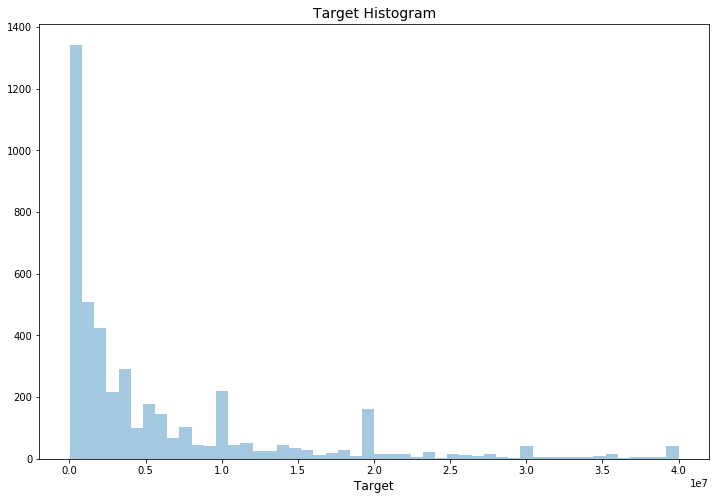

In [8]:
plt.figure(figsize=(12,8))
sns.distplot(train_df["target"].values, bins=50, kde=False)
plt.xlabel('Target', fontsize=12)
plt.title("Target Histogram", fontsize=14)
plt.show()

This is a right (Thanks to Wesam for pointing out my mistake) skewed distribution with majority of the data points having low value. Our competition admins are aware of this one and so they have chosen the evaluation metric as RMSLE (Root Mean Squared Logarithmic Error.).

So let us do a histogram plot on the log of target variables and recheck again.

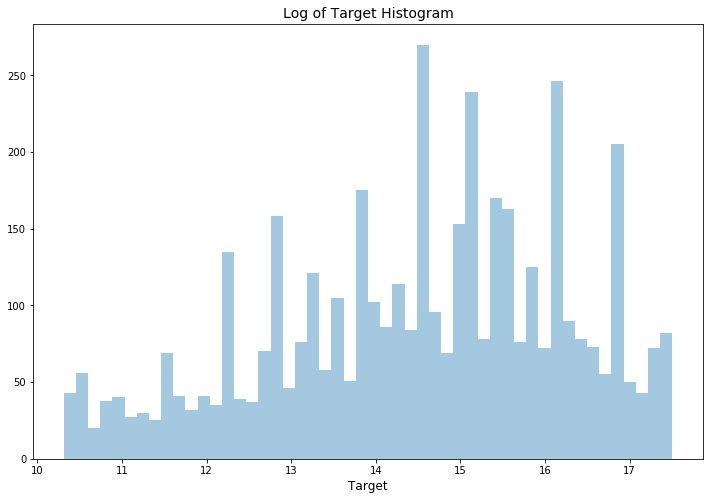

In [9]:
plt.figure(figsize=(12,8))
sns.distplot( np.log1p(train_df["target"].values), bins=50, kde=False)
plt.xlabel('Target', fontsize=12)
plt.title("Log of Target Histogram", fontsize=14)
plt.show()

This looks much better than the old one.

# Missing values:

Now let us check if there are missing values in the dataset.

In [13]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


There are no missing values in the dataset :)

# Data Type of Columns:

Now let us also check the data type of the columns.

In [16]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,3147
1,float64,1845
2,object,1


Majority of the columns are of integer type and the rest are float type. There is only one string column which is nothing but 'ID' column.

# Columns with constant values:

Generally when we get problems with many columns, there might be few columns with constant value in train set. So we can check that one as well.

In [18]:
unique_df = train_df.nunique().reset_index()
unique_df.columns = ["col_name", "unique_count"]
constant_df = unique_df[unique_df["unique_count"]==1]
constant_df.shape

(256, 2)

So we have 256 columns with constant values in the train set. Probably it is a good idea to remove them from the training. Just printing out the names below for ease.

In [19]:
str(constant_df.col_name.tolist())

"['d5308d8bc', 'c330f1a67', 'eeac16933', '7df8788e8', '5b91580ee', '6f29fbbc7', '46dafc868', 'ae41a98b6', 'f416800e9', '6d07828ca', '7ac332a1d', '70ee7950a', '833b35a7c', '2f9969eab', '8b1372217', '68322788b', '2288ac1a6', 'dc7f76962', '467044c26', '39ebfbfd9', '9a5ff8c23', 'f6fac27c8', '664e2800e', 'ae28689a2', 'd87dcac58', '4065efbb6', 'f944d9d43', 'c2c4491d5', 'a4346e2e2', '1af366d4f', 'cfff5b7c8', 'da215e99e', '5acd26139', '9be9c6cef', '1210d0271', '21b0a54cb', 'da35e792b', '754c502dd', '0b346adbd', '0f196b049', 'b603ed95d', '2a50e001c', '1e81432e7', '10350ea43', '3c7c7e24c', '7585fce2a', '64d036163', 'f25d9935c', 'd98484125', '95c85e227', '9a5273600', '746cdb817', '6377a6293', '7d944fb0c', '87eb21c50', '5ea313a8c', '0987a65a1', '2fb7c2443', 'f5dde409b', '1ae50d4c3', '2b21cd7d8', '0db8a9272', '804d8b55b', '76f135fa6', '7d7182143', 'f88e61ae6', '378ed28e0', 'ca4ba131e', '1352ddae5', '2b601ad67', '6e42ff7c7', '22196a84c', '0e410eb3d', '992e6d1d3', '90a742107', '08b9ec4ae', 'd95203ded

# Correlation of features with target:

Now let us find the correlation of the variables with target and plot them. Let us take only those variables whose absolute correlation coefficient is more than 0.2 (just to reduce the number of variables).

C:\Users\Martin\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\Martin\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3184: RuntimeWarning:

invalid value encountered in true_divide



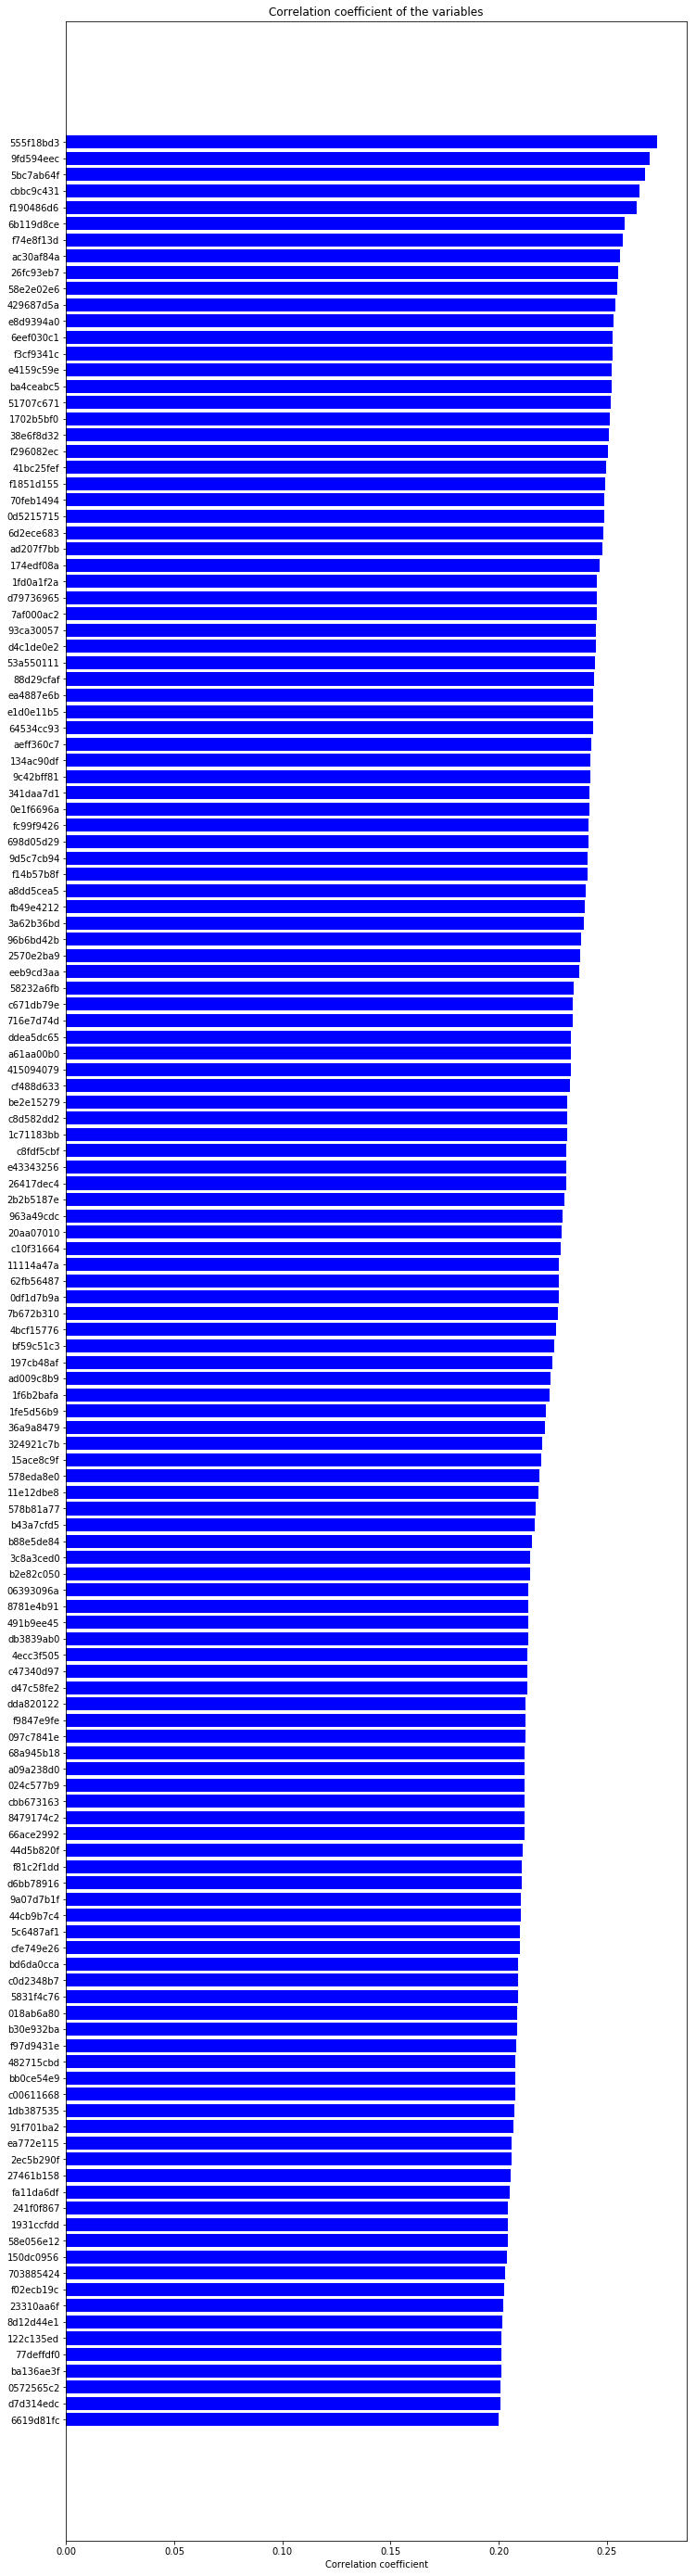

In [24]:
labels = []
values = []
for col in train_df.columns:
    if col not in ["ID", "target"]:
        labels.append(col)
        values.append(np.corrcoef(train_df[col].values, train_df["target"].values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
 
corr_df = corr_df[(corr_df['corr_values']>0.2) | (corr_df['corr_values']<-0.2)]
ind = np.arange(corr_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,50))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

# Correlation Heat Map:

Now let us take those variables whose absolute value of correlation with the target is greater than 0.25 and do a correlation heat map.

# Feature Importance - Extra trees model

Now let us build a Extra tress model and check the important features.

In [29]:
train_X = train_df.drop(constant_df.col_name.tolist() + ["ID", "target"], axis=1)
test_X = test_df.drop(constant_df.col_name.tolist() + ["ID"], axis=1)
train_y = np.log1p(train_df["target"].values)

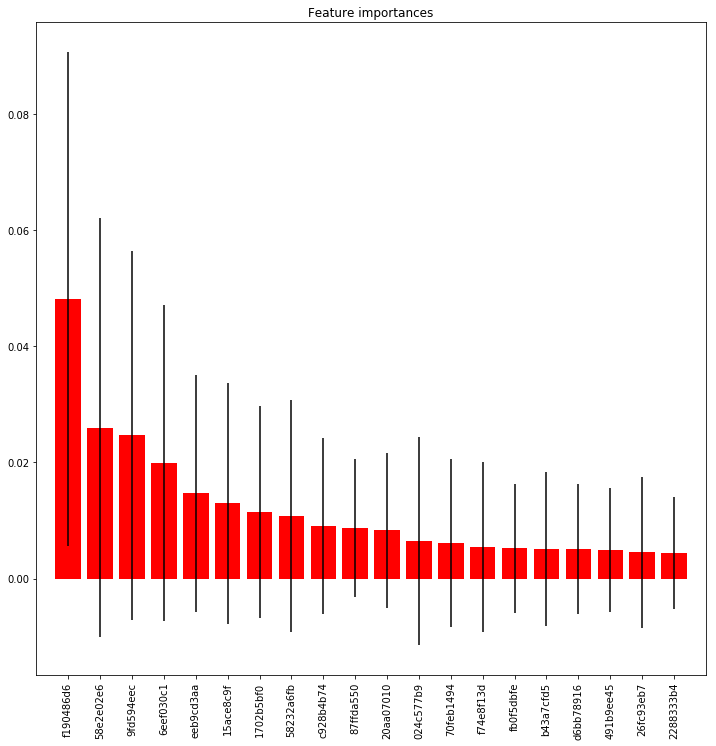

In [30]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)

## plot the importances ##
feat_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

# Feature Importance & Baseline - Light GBM:

Now let us build a baseline Light GBM model and get the feature importances as well.

In [65]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=200, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [66]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
pred_test_full = 0
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
pred_test_full /= 5.
pred_test_full = np.expm1(pred_test_full)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44231
[400]	valid_0's rmse: 1.42178
Early stopping, best iteration is:
[380]	valid_0's rmse: 1.42093
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44249
[400]	valid_0's rmse: 1.40968
[600]	valid_0's rmse: 1.40662
Early stopping, best iteration is:
[532]	valid_0's rmse: 1.40543
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44369
[400]	valid_0's rmse: 1.41905
Early stopping, best iteration is:
[479]	valid_0's rmse: 1.41808
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.49096
[400]	valid_0's rmse: 1.45485
[600]	valid_0's rmse: 1.44857
[800]	valid_0's rmse: 1.44774
[1000]	valid_0's rmse: 1.44622
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 1.44611
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.48257
[400]	valid_0's rmse:

In [58]:
# Making a submission file #
sub_df = pd.DataFrame({"ID":test_df["ID"].values})
sub_df["target"] = pred_test_full
sub_df.to_csv("sub.csv", index=False)

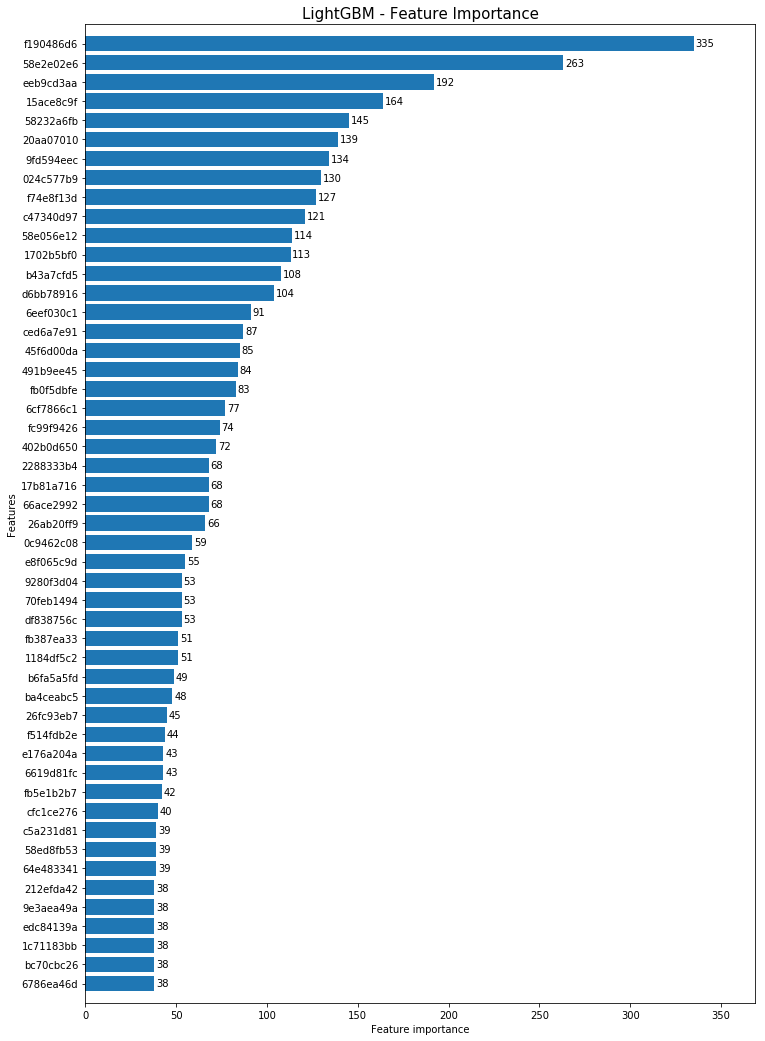

In [59]:
### Feature Importance ###
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()